# PART3 パラメータをチューニングしてみよう

正確にはハイパーパラメータと言う。\
ハイパーパラメータとは、データに合わせて、設定しておかなければならない値のこと\
モデルが複雑になるほどパラメータ数は増加する傾向にある\

決定木の重要なパラメータ
- max_depth（決定木の深さ）
 - 深ければ深いほど、分岐数も増えるため、説明力が上がる
 - 深すぎると意味のない分岐もできやすく、過学習のおそれがある
- min_samples_leaf(葉に属する最小サンプル数)
 - 葉に所属する最低サンプル数を制御できる
 - サンプル数が少ない=信憑性の低い分岐の可能性

## おまじない

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# ジュピターノートブック上でグラフを表示させるための処理
%matplotlib inline

In [11]:
# 決定木ライブラリ
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# 決定木の可視化をするために必要
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

## データの読み込み
- train.csvとtest.csvとsubmit_sample.csvの３つのファイルを読み込みましょう
- それぞれを読み込んだものは変数はtrain, test, sampleに代入しましょう

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('submit_sample.csv', header=None)

## trainから説明変数となるデータを取り出しましょう
- iloc[]を使います
- y以外を説明変数として取り出し、変数trainXに代入しましょう

In [4]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [5]:
# 全ての行を指定したいので行は":"、列はy以外使用したいので、"0:17"
trainX = train.iloc[:, 0:17]

## trainから目的変数となるデータを取り出しましょう
- yを選択し、変数yに代入しましょう

In [6]:
y = train['y']

## testから説明変数となるデータを取り出しましょう
- testの全てのカラムが説明変数となりますので、copy関数を使って変数testXに代入します

In [7]:
testX = test.copy()

## trainXとtestXをダミー変数化しましょう

In [8]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

## 決定木モデルの箱を用意しましょう
- 変数名をclf1とし、DT()を代入しましょう
- パラメータは一旦、max_depth=2, min_samples_leaf=500としましょう

In [9]:
clf1 = DT(max_depth=2, min_samples_leaf=500)

## クロスバリデーションをしてclf1の精度を確かめてみましょう
- cross_validate関数を使います
- オプションには、clf1, trainX, y, cv=5, scoring="roc_auc",n_jobs=-1と書きます

In [13]:
# "cv"はデータを何分割するかを指定
# "scoring"は評価尺度を指定
# "n_jobs"は並列処理をするかしないかで-1を指定することで、並列処理を行う
cross_validate(clf1, trainX, y, cv=5, scoring="roc_auc",n_jobs=-1)

{'fit_time': array([0.03904295, 0.03839827, 0.03939986, 0.0457859 , 0.0463748 ]),
 'score_time': array([0.00620413, 0.00654387, 0.00635695, 0.00487399, 0.00665712]),
 'test_score': array([0.74657601, 0.76182968, 0.73117591, 0.73708019, 0.75909278])}

⬆︎どの回の分析でもスコアはあまり変わっていないことがわかる、つまりばらつきがあまりない

## 異なるパラメータでもう一度決定木の箱を準備しましょう
- 変数はclf2としましょう
- パラメータはmax_depth=10, min_samples_leaf=500としましょう

In [14]:
clf2 = DT(max_depth=10, min_samples_leaf=500)

## クロスバリデーションをしてclf2の精度を確かめてみましょう

In [15]:
cross_validate(clf2, trainX, y, cv=5, scoring="roc_auc",n_jobs=-1)

{'fit_time': array([0.11375475, 0.10165715, 0.10700011, 0.10126805, 0.09888411]),
 'score_time': array([0.00462508, 0.00529099, 0.00455499, 0.00466895, 0.00543094]),
 'test_score': array([0.88264002, 0.88482571, 0.86778474, 0.89238631, 0.88344359])}

⬆︎どの回の分析でもスコアはあまり変わっていないことがわかる、つまりばらつきがあまりない

## 新たな決定木モデルの箱を準備しましょう

手動でパラメータを設定するのは大変なため、自動でパラメータを設定できるようにする

- 変数clf3とし、今回は特にパラメータはセットしません

In [16]:
clf3 = DT()

## グリッドサーチを試してみましょう
- パラメータの範囲を指定し、その範囲をしらみつぶしに調べることで、最適なパラメータを探索することをグリッドサーチといいます
- グリッドサーチ＋クロスバリデーションの組み合わせは良くパラメータ探索の方法として利用されます
- まず探索するパラメータの範囲を表す変数parametersを作ります
- この変数を作る時、"カギ"括弧ではなく、"波"括弧であることに注意して下さい
- {"パラメータの名前①":[範囲], "パラメータの名前②":[範囲]...}のように書きます
- 今回はmax_depthを2から10まで探索してみます

In [18]:
parameters = {"max_depth": [2,3,4,5,6,7,8,9,10]}

In [22]:
# ⬆︎と同じ意味になる
parameters = {"max_depth": list(range(2,11))}

In [21]:
parameters

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

## グリッドサーチ+クロスバリデーションで最適なパラメータを探してみましょう

- GridSearchCV関数を使います
- オプションとして、clf3, parameters, cv=5, scoring="roc_auc",n_jobs=-1と書きます
- グリッドサーチの結果は、変数gcvに代入しましょう
- その後、fit関数を使って、探索をしましょう

In [31]:
gcv = GridSearchCV(clf3, parameters, cv=5, scoring="roc_auc",n_jobs=-1, return_train_score=True)
gcv.fit(trainX, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

## グリッドサーチの結果を見てみましょう
- cv_results_で結果を見る事が出来ます

In [32]:
gcv

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [33]:
gcv.cv_results_

{'mean_fit_time': array([0.05613542, 0.07571812, 0.10305929, 0.11845117, 0.13727217,
        0.15405192, 0.169382  , 0.17368655, 0.18352461]),
 'std_fit_time': array([0.0037884 , 0.00379165, 0.00497202, 0.00179192, 0.00116214,
        0.00307498, 0.00774158, 0.01365358, 0.02799325]),
 'mean_score_time': array([0.00648994, 0.00720162, 0.00702615, 0.00698919, 0.00691695,
        0.00713005, 0.00664167, 0.00584602, 0.00593796]),
 'std_score_time': array([0.0003576 , 0.00040809, 0.00016442, 0.00101904, 0.00103569,
        0.00066703, 0.00140059, 0.00076839, 0.00099474]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'split0_t

## cv_results_の中で重要な２つをみてみましょう
- cv_results_["mean_train_score"]とcv_results_["mean_test_score"]です
- それぞれ変数train_scoreとtest_scoreに代入しましょう

In [34]:
train_score = gcv.cv_results_["mean_train_score"]

In [36]:
train_score

array([0.74831988, 0.81244475, 0.84413657, 0.85726168, 0.86924868,
       0.88598326, 0.89896252, 0.91025581, 0.92424287])

In [35]:
test_score = gcv.cv_results_["mean_test_score"]

In [37]:
test_score

array([0.74715003, 0.80746041, 0.81410356, 0.82269596, 0.82645604,
       0.82545686, 0.8076639 , 0.78920981, 0.7766737 ])

## train_scoreとtest_scoreを可視化しましょう
- x軸をmax_depth、y軸をaucとしてグラフを描きます
- 何も設定しないとx軸は0からスタートとなり、実際の値とずれてしまうので、調整が必要です
- 調整をする為には、plt.xticks([0,1],[2,3])のように書きます
- 上記のオプションの意味は何もしない時に0のものを2とし、1のものを3とする、という意味になります
- 今回はmax_depthを2～10まで調べたので9点あります

([<matplotlib.axis.XTick at 0x1a297bbb10>,
 <a list of 9 Text xticklabel objects>)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


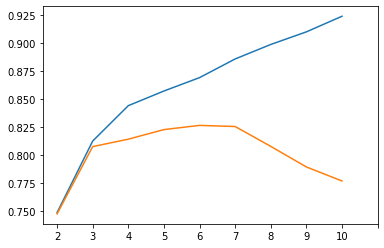

In [38]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0,10)), list(range(2,11)))

⬆︎
青がモデル構築データの精度 \
黄色がモデル検証データの精度

## グリッドサーチで選ばれたパラメータを確認しましょう
- best_params_で結果を見ることができます
 - この結果で選ばれたパラメータが良さそうなパラメータになる

In [39]:
gcv.best_params_

{'max_depth': 6}

## testの予測しましょう
- gcvもpredict_proba関数を持っており、自動的に最適なパラメータを使ったモデルで予測がされます
- 予測結果はpredに代入しましょう。その後、1の確率のみを取り出して、再びpredに代入しましょう

In [40]:
pred = gcv.predict_proba(testX)

In [41]:
pred

array([[0.3390411 , 0.6609589 ],
       [0.54751131, 0.45248869],
       [0.98031963, 0.01968037],
       ...,
       [0.98031963, 0.01968037],
       [0.98031963, 0.01968037],
       [0.98031963, 0.01968037]])

In [42]:
# 全ての行の1である確率を表示
## ":"で全ての行を指定している。
pred[:, 1]

array([0.6609589 , 0.45248869, 0.01968037, ..., 0.01968037, 0.01968037,
       0.01968037])

In [43]:
pred = pred[:, 1]

## predをsample[1]に代入してファイル出力し、DeepAnalyticsへ投稿しましょう
- ファイル名は「submit3_bank.csv」としましょう
- index=None,header=Noneのオプションを忘れないように書きだしましょう

In [44]:
sample[1] = pred

In [45]:
sample.to_csv("submit3_bank.csv", index=None, header=None)

# 実習

1.新たな決定木モデルの箱を変数clf4として準備してみよう。パラメータの設定は不要です

In [46]:
clf4 = DT()

2.max_depthとmin_samples_leafの値の範囲を指定した変数parameters2を作ろう
- max_depthは2～10まで、min_samples_leafは[5,10,20,50,100,500]にしましょう

In [47]:
parameters_2 = {"max_depth": list(range(2,11)),
                          "min_samples_leaf": [5,10,20,50,100,500]}

3.グリッドサーチ+クロスバリデーションで最適なパラメータを探そう。グリッドサーチの結果は変数gcv2に代入しよう

In [48]:
gcv2 = GridSearchCV(clf4, parameters_2, cv=5, scoring="roc_auc",n_jobs=-1, return_train_score=True)
gcv2.fit(trainX, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]

4.最適なパラメータはなんだったか確かめてみよう

In [50]:
train_score2 = gcv2.cv_results_["mean_train_score"]

In [51]:
train_score2

array([0.74831988, 0.74831988, 0.74831988, 0.74831988, 0.74831988,
       0.74831988, 0.81244475, 0.81244475, 0.81244475, 0.81244475,
       0.8125118 , 0.8212394 , 0.84410555, 0.84407739, 0.84405979,
       0.84398245, 0.84382491, 0.85095261, 0.85719269, 0.85713234,
       0.85787943, 0.860413  , 0.85960279, 0.87215656, 0.86954164,
       0.86936272, 0.87122248, 0.87213608, 0.87074767, 0.88291756,
       0.88588643, 0.8852947 , 0.88721433, 0.88522245, 0.88292045,
       0.88793856, 0.89935467, 0.89905488, 0.89862189, 0.89418524,
       0.89294868, 0.88896095, 0.91187443, 0.91111549, 0.90795901,
       0.90270264, 0.90087837, 0.88898577, 0.9264093 , 0.92243972,
       0.91826653, 0.91077137, 0.90725228, 0.88898577])

In [52]:
test_score2 = gcv2.cv_results_["mean_test_score"]

In [53]:
test_score2

array([0.74715003, 0.74715003, 0.74715003, 0.74715003, 0.74715003,
       0.74715003, 0.80746041, 0.80746041, 0.80746041, 0.80746041,
       0.80771113, 0.82025616, 0.81431736, 0.83840087, 0.83842945,
       0.83842857, 0.83834716, 0.84884488, 0.82287397, 0.84647544,
       0.84935445, 0.85426631, 0.85355378, 0.86966131, 0.83012438,
       0.85450317, 0.86012147, 0.8626277 , 0.86275627, 0.87909134,
       0.83324377, 0.86272358, 0.87022848, 0.87222022, 0.87108147,
       0.88219076, 0.83529839, 0.86787734, 0.87656701, 0.87949927,
       0.87956809, 0.88215622, 0.82842537, 0.86869638, 0.88160962,
       0.88531714, 0.88562298, 0.88221599, 0.81824173, 0.86998789,
       0.88442654, 0.89096265, 0.89021334, 0.88221599])

In [54]:
gcv2.best_params_

{'max_depth': 10, 'min_samples_leaf': 50}

5.testの予測をし、予測結果のうち、１となる確率のみを変数pred2に代入しよう

In [55]:
pred2 = gcv2.predict_proba(testX)

In [56]:
pred2

array([[0.18644068, 0.81355932],
       [0.41666667, 0.58333333],
       [0.98916523, 0.01083477],
       ...,
       [0.98916523, 0.01083477],
       [0.98916523, 0.01083477],
       [0.98916523, 0.01083477]])

In [58]:
pred2 = pred2[:, 1]

In [59]:
pred2

array([0.81355932, 0.58333333, 0.01083477, ..., 0.01083477, 0.01083477,
       0.01083477])

6.pred2をsample[1]に代入して"submit4_bank.csv"としてファイル出力し、DeepAnalyticsへ投稿しよう

In [60]:
sample2 = pd.read_csv('submit_sample.csv', header=None)
sample2[1] = pred2
sample2.to_csv("submit4_bank.csv", index=None, header=None)